In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import plot_importance
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score


/home/hice1/hgaur8/.conda/envs/ml_project/lib/python3.11/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [2]:
blca_df = pd.read_csv("BLCA_gene_exp.csv", index_col=0)
cesc_df = pd.read_csv("CESC_gene_exp.csv", index_col=0)
kirc_df = pd.read_csv("KIRC_gene_exp.csv", index_col=0)
hnsc_df = pd.read_csv("HNSC_gene_exp.csv", index_col=0)
lgg_df = pd.read_csv("LGG_gene_exp.csv", index_col=0)
gbm_df = pd.read_csv("GBM_gene_exp.csv", index_col=0)

In [3]:
df_list = [blca_df, cesc_df, kirc_df, hnsc_df, lgg_df, gbm_df]
cancer_type = ['BLCA', 'CESC', 'KIRC', 'HNSC', 'LGG', 'GBM']

for df, c_type in zip(df_list, cancer_type):
    df['cancer_type'] = c_type
    print(f' Shape: {df.shape}')

 Shape: (426, 20531)
 Shape: (307, 20531)
 Shape: (606, 20531)
 Shape: (566, 20531)
 Shape: (529, 20531)
 Shape: (518, 12043)


In [4]:
#find intersecting genes
common_genes = set(df_list[0].columns)
for df in df_list[1:]:
    common_genes &= set(df.columns)

#merge data on common genes
dfs_filtered = [df[list(common_genes)] for df in df_list]
merged_df = pd.concat(dfs_filtered, axis=0)

print(f"Merged Data Shape: {merged_df.shape}")
# print(merged_df.head())

#save merged dataframe
# merged_df.to_csv("merged_counts.csv")

Merged Data Shape: (2952, 11313)


In [5]:
# merged_df

In [6]:
# Encoding data for XgBoost 
diagnoses = {'KIRC': 0,
             'HNSC': 1, 
             'GBM': 2,
             'CESC':3,
             'BLCA':4,
             'LGG':5}
merged_df['cancer_type'] = merged_df['cancer_type'].map(diagnoses)

In [7]:
#obtain features and labels from merged dataset
X = merged_df.loc[:, merged_df.columns != "cancer_type"]
y = merged_df["cancer_type"]

#select top 5000  variable genes
gene_variance = X.var(axis=0)
hv_genes = gene_variance.nlargest(5000).index
X_selected = X[hv_genes]

#rebalance class labels using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_selected, y)

# Step 5: Split Data into Train and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)


## XgBoost

In [8]:
xgb_model = xgb.XGBClassifier(objective='multi:softmax', 
                            num_class=6, 
                            early_stopping_rounds=10, 
                            seed=42)
xgb_model.fit(X_train, 
            y_train,
            verbose=0, # set to 1 to see xgb training round intermediate results
            eval_set=[(X_train, y_train), (X_test, y_test)])

y_pred = xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred))


Accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       121
           1       1.00      1.00      1.00       121
           2       1.00      1.00      1.00       121
           3       1.00      1.00      1.00       122
           4       1.00      1.00      1.00       122
           5       1.00      1.00      1.00       121

    accuracy                           1.00       728
   macro avg       1.00      1.00      1.00       728
weighted avg       1.00      1.00      1.00       728



In [9]:
original_name = {v: k for k, v in diagnoses.items()}
y_test_named = [original_name[label] for label in y_test]
y_pred_named = [original_name[label] for label in y_pred]
print(classification_report(y_test_named, y_pred_named))


              precision    recall  f1-score   support

        BLCA       1.00      1.00      1.00       122
        CESC       1.00      1.00      1.00       122
         GBM       1.00      1.00      1.00       121
        HNSC       1.00      1.00      1.00       121
        KIRC       1.00      1.00      1.00       121
         LGG       1.00      1.00      1.00       121

    accuracy                           1.00       728
   macro avg       1.00      1.00      1.00       728
weighted avg       1.00      1.00      1.00       728



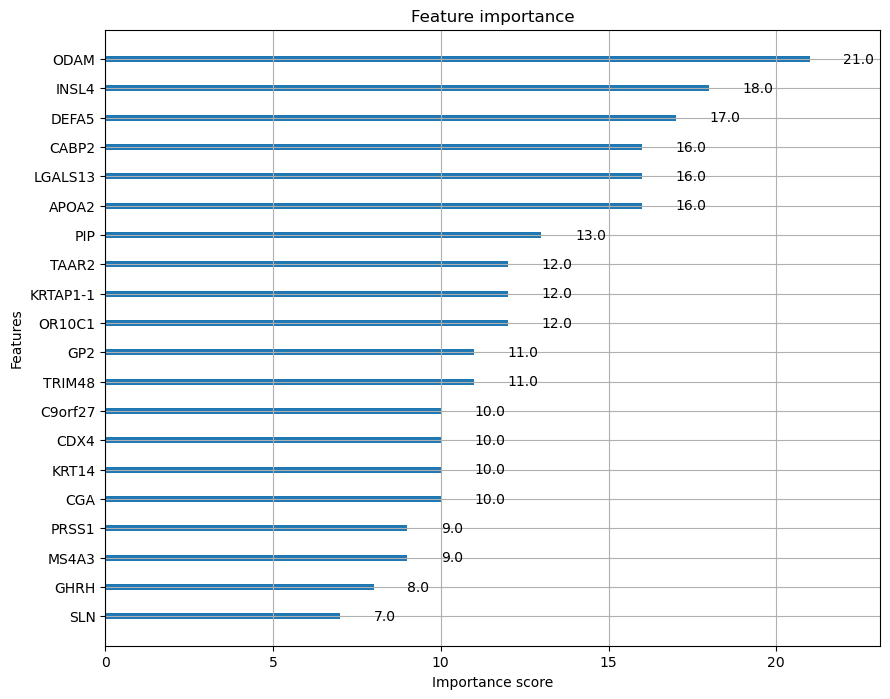

In [19]:
# Feature importance plot

figure, axes = plt.subplots(figsize=(10,8))
plot_importance(xgb_model, ax=ax, max_num_features=20)
plt.show()

In [10]:

parameters = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.04, 0.08, 0.1]
}

xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=6, seed=42)

random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=parameters,
    scoring='accuracy',
    cv=3,
    verbose=1,
    random_state=42
)
random_search.fit(X_train, y_train)

print(f"Best Parameters:\n{random_search.best_params_}")


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters:
{'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.08}


/home/hice1/hgaur8/.conda/envs/ml_project/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:31:57] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1744352472081/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/hice1/hgaur8/.conda/envs/ml_project/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:32:11] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1744352472081/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/hice1/hgaur8/.conda/envs/ml_project/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:32:28] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1744352472081/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/hice1/hgaur8/.conda/envs/ml_pro

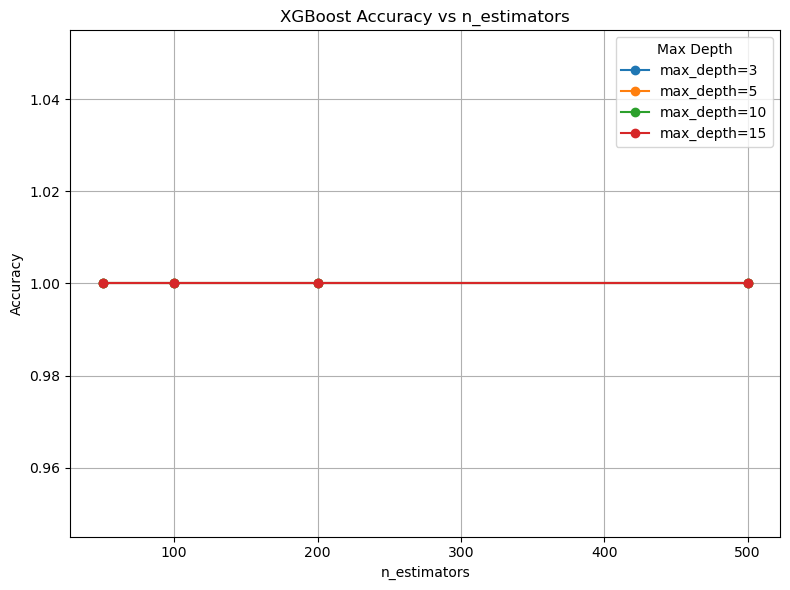

In [14]:


n_estimators_range = [50, 100, 200, 500]
max_depth_range = [3, 5, 10, 15]

xgb_results = []

for n in n_estimators_range:
    for d in max_depth_range:
        model = xgb.XGBClassifier(
            objective='multi:softmax',
            num_class=6,
            n_estimators=n,
            max_depth=d,
            use_label_encoder=False,
            eval_metric='mlogloss',
            random_state=42
        )
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        acc = accuracy_score(y_test, preds)
        xgb_results.append({
            "n_estimators": n,
            "max_depth": d,
            "Accuracy": acc
        })

xgb_df = pd.DataFrame(xgb_results)

# Plotting
plt.figure(figsize=(8, 6))
for d in xgb_df["max_depth"].unique():
    subset = xgb_df[xgb_df["max_depth"] == d]
    plt.plot(subset["n_estimators"], subset["Accuracy"], marker="o", label=f"max_depth={d}")

plt.title("XGBoost Accuracy vs n_estimators")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.legend(title="Max Depth")
plt.grid(True)
plt.tight_layout()
plt.show()
